<a href="https://colab.research.google.com/github/SheryllD/diabetic_retinopathy_ml/blob/main/DR_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

import kagglehub

import warnings
warnings.filterwarnings('ignore')

In [57]:
# Install Kaggle API
!pip install -q Kaggle
!apt-get update
!apt-get install tree -y

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set up Kaggle credentials
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Keys/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered --unzip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
License(s): CC0-1.0
 94% 403M/427M [00:00<00:00, 441MB/s]
100% 427M/427M [00:00<00:00, 486MB/s]


In [58]:
# List the main directory after unzip
print("Top-level files and folders:")
print(os.listdir())

Top-level files and folders:
['.config', 'train', 'gaussian_filtered_images', 'train.csv', 'val', 'processed', 'test', 'drive', 'sample_data']


In [82]:
# Load the CSV file into a pandas DataFrame
path = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered"
df = pd.read_csv("/content/train.csv")

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
print(df.head())

# Image folder root
image_root = os.path.join(path, 'gaussian_filtered_images', 'gaussian_filtered_images')

# Output base folder
output_root = "/content/processed"

        id_code  diagnosis binary_type            type
0  000c1434d8d7          2          DR        Moderate
1  001639a390f0          4          DR  Proliferate_DR
2  0024cdab0c1e          1          DR            Mild
3  002c21358ce6          0       No_DR           No_DR
4  005b95c28852          0       No_DR           No_DR


In [83]:
# Reviewing the paths
print("Downloaded path:", path)
print("Contents of the folder:")
print(os.listdir(path))

Downloaded path: /kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered
Contents of the folder:
['gaussian_filtered_images', 'train.csv']


In [84]:
# Images
images = os.path.join(path, 'gaussian_filtered_images', 'gaussian_filtered_images')
print("Contents of the folder:", os.listdir(images))

Contents of the folder: ['Mild', 'Proliferate_DR', 'Moderate', 'export.pkl', 'No_DR', 'Severe']


In [85]:
# import os

# df['image_path'] = df['id_code'].apply(lambda x: os.path.join("gaussian_filtered_images", "train", f"{x}.jpeg"))

In [86]:
# Loading the CSV
print(df.head(10))

        id_code  diagnosis binary_type            type
0  000c1434d8d7          2          DR        Moderate
1  001639a390f0          4          DR  Proliferate_DR
2  0024cdab0c1e          1          DR            Mild
3  002c21358ce6          0       No_DR           No_DR
4  005b95c28852          0       No_DR           No_DR
5  0083ee8054ee          4          DR  Proliferate_DR
6  0097f532ac9f          0       No_DR           No_DR
7  00a8624548a9          2          DR        Moderate
8  00b74780d31d          2          DR        Moderate
9  00cb6555d108          1          DR            Mild


<Axes: xlabel='type'>

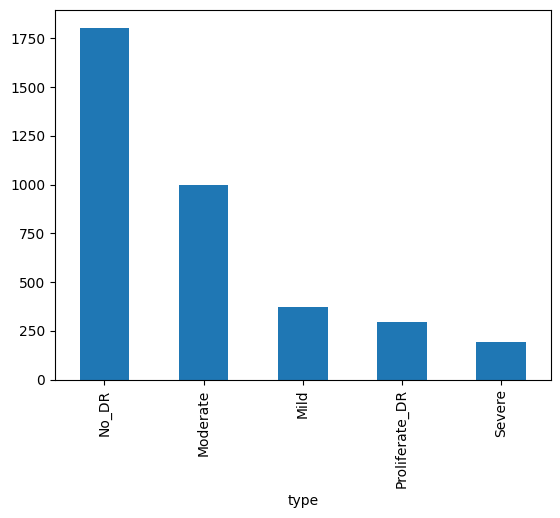

In [87]:
df['type'].value_counts().plot(kind='bar')

<Axes: xlabel='binary_type'>

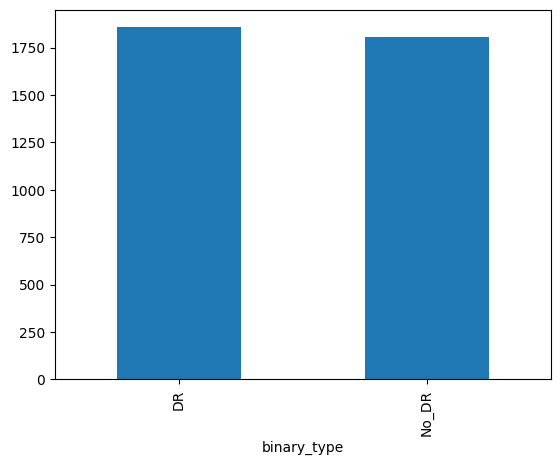

In [88]:
df['binary_type'].value_counts().plot(kind='bar')

In [98]:
# Split into stratified train, val, and test sets
train_mid, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_mid, test_size = 0.15 / (1 - 0.15), stratify = train_mid['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [99]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [100]:
src_dir = "/content/gaussian_filtered_images/gaussian_filtered_images"
print(os.listdir(src_dir))

['Proliferate_DR', 'No_DR', 'Severe', 'Mild', 'export.pkl', 'Moderate']


In [101]:
import os
import shutil

# Step 1: Set up the actual source directory
src_dir = "/content/gaussian_filtered_images/gaussian_filtered_images"  # actual path in Colab

# Step 2: Set up destination working directories
base_dir = "/content/processed"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Step 3: Recreate fresh destination folders
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

# Step 4: Define a function to copy the data
def copy_split(df, split_dir):
    for _, row in df.iterrows():
        diagnosis = row['type']           # e.g. 'Mild', 'Severe', etc.
        binary = row['binary_type']       # 'DR' or 'No_DR'
        filename = row['id_code'] + ".png"

        srcfile = os.path.join(src_dir, diagnosis, filename)
        dst_folder = os.path.join(split_dir, binary)

        os.makedirs(dst_folder, exist_ok=True)

        if os.path.exists(srcfile):
            shutil.copy(srcfile, dst_folder)
        else:
            print(f"[Missing] {srcfile}")

# Step 5: Copy all splits
copy_split(train, train_dir)
copy_split(val, val_dir)
copy_split(test, test_dir)

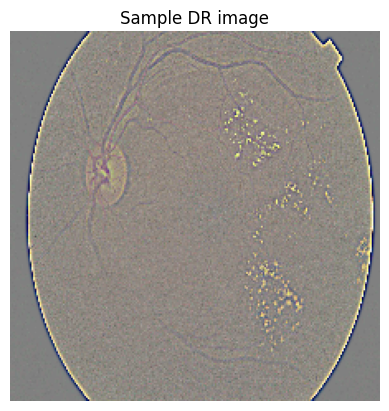

In [102]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

sample_folder = "/content/processed/train/DR"
sample_images = os.listdir(sample_folder)
img_path = os.path.join(sample_folder, random.choice(sample_images))

img = imread(img_path)
plt.imshow(img)
plt.title("Sample DR image")
plt.axis("off")
plt.show()


In [103]:
# Setting up ImageDataGenerator for train/val/test

train_path = '/content/processed/train'
val_path = '/content/processed/val'
test_path = '/content/processed/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32 # You can adjust this batch size

# Set up the training data generator using flow_from_directory
train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    train_path,
    target_size=img_size,
    class_mode='categorical', # Use 'categorical' for binary classification with 2 classes
    shuffle = True,
    batch_size=batch_size
)

# Set up the validation data generator using flow_from_directory
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    val_path,
    target_size=img_size,
    class_mode='categorical',
    shuffle = True, # Shuffle validation data
    batch_size=batch_size
)

# Set up the test data generator using flow_from_directory
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    test_path,
    target_size=img_size,
    class_mode='categorical',
    shuffle = False, # Do not shuffle test data
    batch_size=batch_size # Or use a test_batch_size calculated for testing
)

print("Data generators train_batches, val_batches, and test_batches are now defined.")

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Data generators train_batches, val_batches, and test_batches are now defined.


In [108]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches, epochs=10, validation_data = val_batches)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 745ms/step - acc: 0.7144 - loss: 0.5888 - val_acc: 0.5073 - val_loss: 0.6839
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 699ms/step - acc: 0.8937 - loss: 0.2721 - val_acc: 0.5073 - val_loss: 0.7530
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 703ms/step - acc: 0.9202 - loss: 0.2336 - val_acc: 0.5073 - val_loss: 0.9377
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 707ms/step - acc: 0.9230 - loss: 0.2169 - val_acc: 0.5145 - val_loss: 0.8462
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 56s 697ms/step - acc: 0.9274 - loss: 0.2031 - val_acc: 0.6364 - val_loss: 0.5757
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 56s 697ms/step - acc: 0.9376 - loss: 0.1804 - val_acc: 0.8891 - val_loss: 0.3076
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 58s 719ms/step - acc: 0.9470 - loss: 0.1684 - val_acc: 0.9236 - val_loss: 0.2221
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 56s 686ms/step - acc: 0.9406 - loss: 0.1726 - val_acc: 0.9400 - val_loss: 0.1870
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 710ms/

In [109]:
# Evaluate the model on the test set
print("Evaluating model on the test set:")
loss, acc = model.evaluate(test_batches, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

Evaluating model on the test set:
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - acc: 0.9301 - loss: 0.1859
Test Loss: 0.1925
Test Accuracy: 0.9345


In [110]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get the true labels from the test_batches generator
test_batches.reset()
true_labels = test_batches.classes
class_names = list(test_batches.class_indices.keys())

# Get the model's predictions on the test data
# Use verbose=0 to prevent printing progress bar
predictions = model.predict(test_batches, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Generate the classification report
report = classification_report(true_labels, predicted_classes, target_names=class_names)

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(report)

Confusion Matrix:
[[259  20]
 [ 16 255]]

Classification Report:
              precision    recall  f1-score   support

          DR       0.94      0.93      0.94       279
       No_DR       0.93      0.94      0.93       271

    accuracy                           0.93       550
   macro avg       0.93      0.93      0.93       550
weighted avg       0.93      0.93      0.93       550



In [106]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')

In [111]:
# predict_class('../diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Severe/03c85870824c.png')